# Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df_one = pd.read_csv('/content/drive/MyDrive/PFW_all_2016_2020_June2023_Public.csv')
df_two = pd.read_csv('/content/drive/MyDrive/PFW_all_2021_2023_June2023_Public.csv')

df = pd.concat([df_one, df_two])

<ipython-input-4-ce739a42c6bd>:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_one = pd.read_csv('/content/drive/MyDrive/PFW_all_2016_2020_June2023_Public.csv')


In [ ]:
data_frame = pd.DataFrame(df)

In [ ]:
dropped_columns =['ENTRY_TECHNIQUE', 'SUB_ID', 'OBS_ID',
                 'PROJ_PERIOD_ID', 'alt_full_spp_code',
                 'PLUS_CODE', 'VALID', 'REVIEWED', 'DAY1_AM',
                 'DAY1_PM', 'DAY2_AM', 'DAY2_PM', 'EFFORT_HRS_ATLEAST',
                 'SNOW_DEP_ATLEAST', 'Data_Entry_Method']

data_frame.drop(dropped_columns, axis=1, inplace=True)

In [ ]:
print(data_frame.head())

    LOC_ID   LATITUDE  LONGITUDE SUBNATIONAL1_CODE  Month  Day  Year  \
0  L100025  42.675982 -70.848019             US-MA     12    2  2017   
1  L100025  42.675982 -70.848019             US-MA     12    2  2017   
2  L100025  42.675982 -70.848019             US-MA     12    2  2017   
3  L100025  42.675982 -70.848019             US-MA     12    2  2017   
4  L100025  42.675982 -70.848019             US-MA     12    2  2017   

  SPECIES_CODE  HOW_MANY  
0       tuftit       1.0  
1       houspa       2.0  
2       daejun       1.0  
3       houfin       1.0  
4       blujay       5.0  


In [ ]:
species = []

for index, value in data_frame['SPECIES_CODE'].value_counts().items():
    species.append(index)
    print(index, value)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def custom_sort_key(item):
    month = item[0]
    order = {11: 0, 12: 1, 1: 2, 2: 3, 3: 4, 4: 5}
    return order.get(month, 6)

def heat_map(data_frame, CHOSEN_SPECIES_CODE, plot):
  species = data_frame.groupby(data_frame.SPECIES_CODE)
  species_data = species.get_group(CHOSEN_SPECIES_CODE)

  existing_months = species_data['Month'].unique()
  all_months = list(range(1, 13))
  missing_months = [(month, 0) for month in all_months if month not in existing_months]
  month_freq = [(month, count) for month, count in species_data['Month'].value_counts().items()]
  combined_data = month_freq
  freq_points = sorted(combined_data, key=custom_sort_key)

  months = [x[0] for x in freq_points]
  freq = [x[1] for x in freq_points]
  weighted_freq = [x/sum(freq) for x in freq]

  if plot == True:
    freq_array = np.array(weighted_freq)

    freq_2d = freq_array.reshape(1, -1)

    plt.figure(figsize=(10, 2))

    vmin = min(weighted_freq)
    vmax = max(weighted_freq)

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    plt.imshow(freq_2d, cmap='viridis', aspect='auto', norm=norm)
    plt.colorbar(label='Frequency')
    plt.xticks(ticks=np.arange(len(months)), labels=months)
    plt.xlabel('Month')
    plt.title(f'Frequency of {CHOSEN_SPECIES_CODE} by Month')

    plt.yticks([])
    plt.show()


  return weighted_freq


In [ ]:
i = 0

while i < 5:
  weighted_freq = heat_map(data_frame, species[i], False)
  print(weighted_freq)
  i += 1

[0.13513429039700106, 0.20170907947248848, 0.2162603801817887, 0.1861986314080713, 0.18630216462562973, 0.07439447718655319, 9.76728467532569e-07]
[0.13599834659749532, 0.20204558638379105, 0.21169542648499207, 0.18240743791503547, 0.1789758289726839, 0.08887737364600214]
[0.12820928604036744, 0.1902105543654966, 0.20820672460199585, 0.18467867375331282, 0.18897941140625032, 0.09971534983257695]
[0.12766764421757387, 0.18663514299113287, 0.20005251544667305, 0.18132416726277822, 0.19699019495549153, 0.10733033512635043]
[0.13965287138565383, 0.1972308517707611, 0.20278962910688902, 0.17704494328243908, 0.18414869117173996, 0.09913301328251702]


In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# One-Class SVM

In [ ]:
from sklearn.linear_model import SGDOneClassSVM
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

z = data_frame[['LATITUDE', 'LONGITUDE', 'Month', 'SPECIES_CODE']]
X = z[z['SPECIES_CODE'] == 'daejun']

column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(handle_unknown='ignore'), ['SPECIES_CODE'])],
    remainder='passthrough'
)

X_train_encoded = column_transformer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_encoded)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (819060, 4)
Shape of X_test: (204766, 4)


In [ ]:
import numpy as np

oc_svm = SGDOneClassSVM(nu=0.01, max_iter=1000, tol=1e-4, learning_rate='optimal', shuffle=True, verbose=1, random_state=42)

batch_size = 1000

num_batches = int(np.ceil(len(X_scaled) / batch_size))


for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_scaled))

    X_batch = X_train[start_idx:end_idx]

    if X_batch.shape[0] == 0:
        break
    oc_svm.partial_fit(X_batch)



In [ ]:
from sklearn.metrics import average_precision_score

decision_scores = oc_svm.decision_function(X_test)

print("Decision Scores:")
print(decision_scores)

y_true = (decision_scores > 0).astype(int)

auc_pr = average_precision_score(y_true, decision_scores)

print("True Labels:")
print(y_true)

print("Average Precision (AUC-PR):", auc_pr)

In [ ]:
def distance_to_decision_boundary(decision_scores):
    distances = np.abs(decision_scores)

    if np.min(distances) == np.max(distances):
        normalized_distances = np.full_like(distances, 0.5)
    else:
        normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    prob_scores = 1 - normalized_distances
    return prob_scores


prob_scores_distance = distance_to_decision_boundary(decision_scores)

print("Pseudo-Probabilities based on Distance:")
print(prob_scores_distance)


In [ ]:
import pandas as pd

new_data = [[45, -80, 12, 'daejun']]  # New location and date

new_data_point = pd.DataFrame(new_data, columns=['LATITUDE', 'LONGITUDE', 'Month', 'SPECIES_CODE'])

new_data_point_encoded = column_transformer.transform(new_data_point)
new_data_scaled = scaler.transform(new_data_point_encoded)

new_data_scaled = np.array(new_data_scaled).reshape(1, -1)

X_test_with_new_data = np.vstack([X_test, new_data_scaled])

decision_scores_combined = oc_svm.decision_function(X_test_with_new_data)

probability_new_data = distance_to_decision_boundary(decision_scores_combined)[-1]

prediction = oc_svm.predict(new_data_scaled)

print("Prediction (1 for sighting, -1 for non-sighting):", prediction, probability_new_data)

Prediction (1 for sighting, -1 for non-sighting): [1] 0.7583316553536408


# Saving Model & Data

In [ ]:
import joblib
import numpy as np

joblib.dump(oc_svm, '/content/drive/MyDrive/one_class_svm_model.pkl')

np.savez('/content/drive/MyDrive/testing_data.npz', X_test=X_test_with_new_data)

In [ ]:
from sklearn.externals import joblib
import numpy as np

oc_svm = joblib.load('one_class_svm_model.pkl')

testing_data = np.load('testing_data.npz')
X_test_loaded = testing_data['X_test']

#Graphs

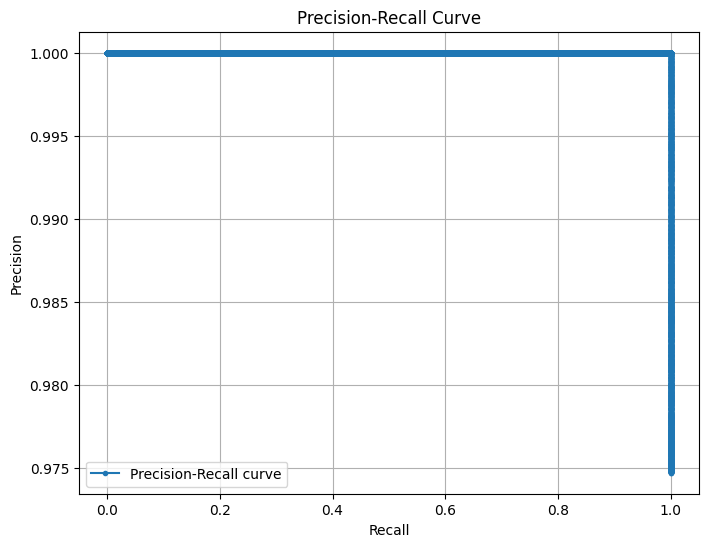

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, decision_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
